In [1]:
!pip install torch_snippets torch_summary --quiet
import itertools
from PIL import Image
from torch_snippets import *
from torchvision import transforms
from torchvision.utils import make_grid
from torchsummary import summary

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.6/79.6 kB 3.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 8.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.5/62.5 kB 7.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 9.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 204.2/204.2 kB 10.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.4/4.4 MB 30.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 48.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.9/98.9 kB 12.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.8/3.8 MB 63.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 30.6/30.6 MB 49.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 177.4/177.4 kB 23.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.4/3.4 MB 104.8 MB/s eta 

In [2]:
# prompt: mount drive

from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
img = Image.open('/content/drive/MyDrive/DL_HW6/HW_06_Dataset/testA/00010.jpg')
img.size

(256, 256)

In [4]:
IMAGE_SIZE = 256
device = 'cuda' if torch.cuda.is_available() else 'cpu'
transform = transforms.Compose([
    transforms.Resize(int(IMAGE_SIZE*1.33)),
    transforms.RandomCrop((IMAGE_SIZE,IMAGE_SIZE)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])

Loading Dataset

In [5]:
class Monet2PhotoDataset(Dataset):
    def __init__(self, monets, photos):

        self.photos = Glob(photos)
        self.monets = Glob(monets)

    def __getitem__(self, ix):
        photo = self.photos[ix % len(self.photos)]

        monet = choose(self.monets)
        photo = Image.open(photo).convert('RGB')
        monet = Image.open(monet).convert('RGB')
        return monet, photo

    def __len__(self): return max(len(self.monets), len(self.photos))
    def choose(self): return self[randint(len(self))]

    def collate_fn(self, batch):

        srcs, trgs = list(zip(*batch))

        srcs = torch.cat([transform(img)[None] for img in srcs], 0).to(device).float()
        trgs = torch.cat([transform(img)[None] for img in trgs], 0).to(device).float()
        return srcs.to(device), trgs.to(device)

In [6]:
trn_ds = Monet2PhotoDataset('/content/drive/MyDrive/DL_HW6/HW_06_Dataset/trainA', '/content/drive/MyDrive/DL_HW6/HW_06_Dataset/trainB')
val_ds = Monet2PhotoDataset('/content/drive/MyDrive/DL_HW6/HW_06_Dataset/testA', '/content/drive/MyDrive/DL_HW6/HW_06_Dataset/testB')

trn_dl = DataLoader(trn_ds, batch_size=1, shuffle=True, collate_fn=trn_ds.collate_fn)
val_dl = DataLoader(val_ds, batch_size=5, shuffle=True, collate_fn=val_ds.collate_fn)

In [7]:
def weights_init_normal(m):
    classname = m.__class__.__name__
    if classname.find("Conv") != -1:
        torch.nn.init.normal_(m.weight.data, 0.0, 0.02)
        if hasattr(m, "bias") and m.bias is not None:
            torch.nn.init.constant_(m.bias.data, 0.0)
    elif classname.find("BatchNorm2d") != -1:
        torch.nn.init.normal_(m.weight.data, 1.0, 0.02)
        torch.nn.init.constant_(m.bias.data, 0.0)

In [8]:
class ResidualBlock(nn.Module):
    def __init__(self, in_features):
        super(ResidualBlock, self).__init__()

        self.block = nn.Sequential(
            nn.ReflectionPad2d(1),
            nn.Conv2d(in_features, in_features, 3),
            nn.InstanceNorm2d(in_features),
            nn.ReLU(inplace=True),
            nn.ReflectionPad2d(1),
            nn.Conv2d(in_features, in_features, 3),
            nn.InstanceNorm2d(in_features),
        )

    def forward(self, x):
        return x + self.block(x)

Generator

In [9]:
class GeneratorResNet(nn.Module):
    def __init__(self, num_residual_blocks=9):
        super(GeneratorResNet, self).__init__()
        out_features = 64
        channels = 3
        model = [
            nn.ReflectionPad2d(3),
            nn.Conv2d(channels, out_features, 7),
            nn.InstanceNorm2d(out_features),
            nn.ReLU(inplace=True),
        ]
        in_features = out_features
        # Downsampling
        for _ in range(2):
            out_features *= 2
            model += [
                nn.Conv2d(in_features, out_features, 3, stride=2, padding=1),
                nn.InstanceNorm2d(out_features),
                nn.ReLU(inplace=True),
            ]
            in_features = out_features

        # Residual blocks
        for _ in range(num_residual_blocks):
            model += [ResidualBlock(out_features)]

        # Upsampling
        for _ in range(2):
            out_features //= 2
            model += [
                nn.Upsample(scale_factor=2),
                nn.Conv2d(in_features, out_features, 3, stride=1, padding=1),
                nn.InstanceNorm2d(out_features),
                nn.ReLU(inplace=True),
            ]
            in_features = out_features

        # Output layer
        model += [nn.ReflectionPad2d(channels), nn.Conv2d(out_features, channels, 7), nn.Tanh()]
        self.model = nn.Sequential(*model)
        self.apply(weights_init_normal)
    def forward(self, x):
        return self.model(x)

Discriminator

In [10]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()

        channels, height, width = 3, IMAGE_SIZE, IMAGE_SIZE

        def discriminator_block(in_filters, out_filters, normalize=True):
            """Returns downsampling layers of each discriminator block"""
            layers = [nn.Conv2d(in_filters, out_filters, 4, stride=2, padding=1)]
            if normalize:
                layers.append(nn.InstanceNorm2d(out_filters))
            layers.append(nn.LeakyReLU(0.2, inplace=True))
            return layers

        self.model = nn.Sequential(
            *discriminator_block(channels, 64, normalize=False),
            *discriminator_block(64, 128),
            *discriminator_block(128, 256),
            *discriminator_block(256, 512),
            nn.ZeroPad2d((1, 0, 1, 0)),
            nn.Conv2d(512, 1, 4, padding=1)
        )
        self.apply(weights_init_normal)

    def forward(self, img):
        return self.model(img)

In [11]:
@torch.no_grad()
def generate_sample():
    data = next(iter(val_dl))
    G_AB.eval()
    G_BA.eval()

    real_A, real_B = data
    fake_B = G_AB(real_A)
    fake_A = G_BA(real_B)
    # Arange images along x-axis
    real_A = make_grid(real_A, nrow=5, normalize=True)
    real_B = make_grid(real_B, nrow=5, normalize=True)
    fake_A = make_grid(fake_A, nrow=5, normalize=True)
    fake_B = make_grid(fake_B, nrow=5, normalize=True)
    # Arange images along y-axis
    image_grid = torch.cat((real_A, fake_B, real_B, fake_A), 1)
    show(image_grid.detach().cpu().permute(1,2,0).numpy(), sz=12)

Generator Training

In [12]:
def generator_train_step(Gs, optimizer, real_A, real_B):
    G_AB, G_BA = Gs
    optimizer.zero_grad()
    loss_id_A = criterion_identity(G_BA(real_A), real_A)
    loss_id_B = criterion_identity(G_AB(real_B), real_B)

    loss_identity = (loss_id_A + loss_id_B) / 2
    fake_B = G_AB(real_A)
    loss_GAN_AB = criterion_GAN(D_B(fake_B), torch.Tensor(np.ones((len(real_A), 1, 16, 16))).to(device))
    fake_A = G_BA(real_B)
    loss_GAN_BA = criterion_GAN(D_A(fake_A), torch.Tensor(np.ones((len(real_A), 1, 16, 16))).to(device))

    loss_GAN = (loss_GAN_AB + loss_GAN_BA) / 2
    recov_A = G_BA(fake_B)
    loss_cycle_A = criterion_cycle(recov_A, real_A)
    recov_B = G_AB(fake_A)
    loss_cycle_B = criterion_cycle(recov_B, real_B)

    loss_cycle = (loss_cycle_A + loss_cycle_B) / 2
    loss_G = loss_GAN + lambda_cyc * loss_cycle + lambda_id * loss_identity
    loss_G.backward()
    optimizer.step()
    return loss_G, loss_identity, loss_GAN, loss_cycle, loss_G, fake_A, fake_B

Discriminator Training

In [13]:
def discriminator_train_step(D, real_data, fake_data, optimizer):
    optimizer.zero_grad()
    loss_real = criterion_GAN(D(real_data), torch.Tensor(np.ones((len(real_data), 1, 16, 16))).to(device))
    loss_fake = criterion_GAN(D(fake_data.detach()), torch.Tensor(np.zeros((len(real_data), 1, 16, 16))).to(device))
    loss_D = (loss_real + loss_fake) / 2
    loss_D.backward()
    optimizer.step()
    return loss_D

In [14]:
G_AB = GeneratorResNet().to(device)
G_BA = GeneratorResNet().to(device)
D_A = Discriminator().to(device)
D_B = Discriminator().to(device)

criterion_GAN = torch.nn.MSELoss()
criterion_cycle = torch.nn.L1Loss()
criterion_identity = torch.nn.L1Loss()

optimizer_G = torch.optim.Adam(
    itertools.chain(G_AB.parameters(), G_BA.parameters()), lr=0.0002, betas=(0.5, 0.999)
)
optimizer_D_A = torch.optim.Adam(D_A.parameters(), lr=0.0002, betas=(0.5, 0.999))
optimizer_D_B = torch.optim.Adam(D_B.parameters(), lr=0.0002, betas=(0.5, 0.999))

lambda_cyc, lambda_id = 10.0, 5.0

Training Cycle GAN

In [15]:
n_epochs = 5
log = Report(n_epochs)
for epoch in range(n_epochs):
    N = len(trn_dl)
    for bx, batch in enumerate(trn_dl):
        real_A, real_B = batch

        loss_G, loss_identity, loss_GAN, loss_cycle, loss_G, fake_A, fake_B = generator_train_step((G_AB,G_BA), optimizer_G, real_A, real_B)
        loss_D_A = discriminator_train_step(D_A, real_A, fake_A, optimizer_D_A)
        loss_D_B = discriminator_train_step(D_B, real_B, fake_B, optimizer_D_B)
        loss_D = (loss_D_A + loss_D_B) / 2

        log.record(epoch+(1+bx)/N, loss_D=loss_D.item(), loss_G=loss_G.item(),
                   loss_GAN=loss_GAN.item(), loss_cycle=loss_cycle.item(),
                   loss_identity=loss_identity.item(), end='\r')
    generate_sample()

    log.report_avgs(epoch+1)

Output hidden; open in https://colab.research.google.com to view.

In [16]:

torch.save(G_AB.state_dict(), '/content/drive/MyDrive/DL_HW6/models/G_AB.pth')
torch.save(G_BA.state_dict(), '/content/drive/MyDrive/DL_HW6/models/G_BA.pth')
torch.save(D_A.state_dict(), '/content/drive/MyDrive/DL_HW6/models/D_A.pth')
torch.save(D_B.state_dict(), '/content/drive/MyDrive/DL_HW6/models/D_B.pth')


100%|██████████| 106/106 [00:03<00:00, 33.03it/s]


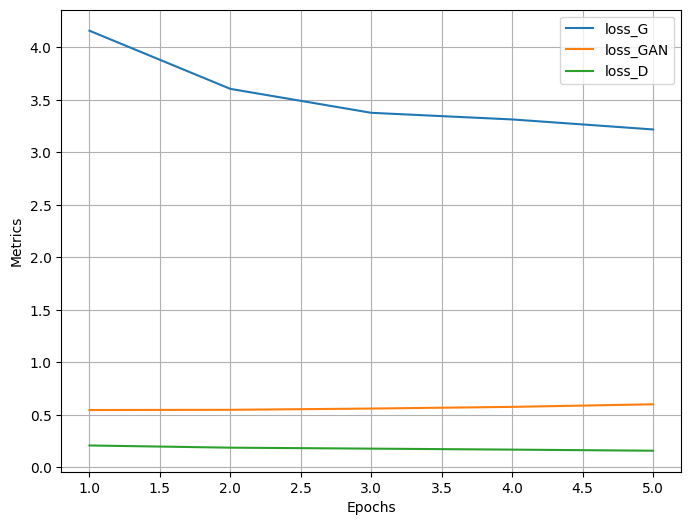

In [17]:
log.plot_epochs(['loss_G','loss_GAN', 'loss_D'])

In [18]:
# Load the model parameters
G_AB.load_state_dict(torch.load('/content/drive/MyDrive/DL_HW6/models/G_AB.pth'))
G_BA.load_state_dict(torch.load('/content/drive/MyDrive/DL_HW6/models/G_BA.pth'))
D_A.load_state_dict(torch.load('/content/drive/MyDrive/DL_HW6/models/D_A.pth'))
D_B.load_state_dict(torch.load('/content/drive/MyDrive/DL_HW6/models/D_B.pth'))

<All keys matched successfully>

few results from validation dataset

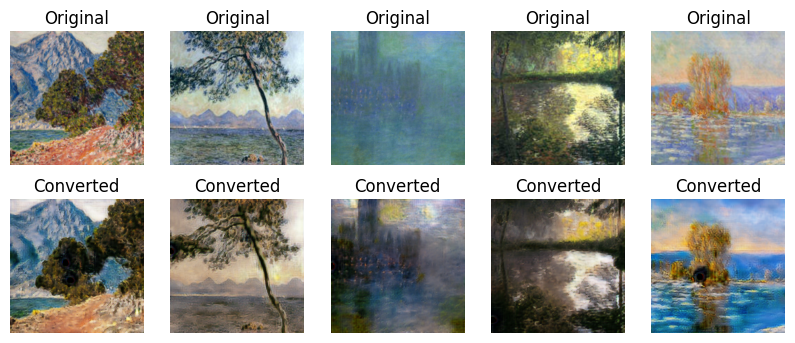

In [21]:
%matplotlib inline
import matplotlib.pyplot as plt
import torch

def denormalize(image):

    return (image + 1) / 2

def clamp_images(image):
    return image.clamp(0, 1)


def show_images(originals, converted, n=5):
    plt.figure(figsize=(10, 4))
    for i in range(n):

        original = denormalize(originals[i])
        converted_img = denormalize(converted[i])

        plt.subplot(2, n, i + 1)
        plt.imshow(original.permute(1, 2, 0).cpu().numpy())
        plt.title('Original')
        plt.axis('off')


        plt.subplot(2, n, n + i + 1)
        plt.imshow(converted_img.permute(1, 2, 0).cpu().numpy())
        plt.title('Converted')
        plt.axis('off')
    plt.show()


for real_A, real_B in val_dl:
    with torch.no_grad():
        fake_B = G_AB(real_A.to(device))


    show_images(real_A, fake_B, n=5)

    break


Inferencing on completely new unseen data

In [22]:
G_AB.eval()

GeneratorResNet(
  (model): Sequential(
    (0): ReflectionPad2d((3, 3, 3, 3))
    (1): Conv2d(3, 64, kernel_size=(7, 7), stride=(1, 1))
    (2): InstanceNorm2d(64, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (3): ReLU(inplace=True)
    (4): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (5): InstanceNorm2d(128, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (8): InstanceNorm2d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (9): ReLU(inplace=True)
    (10): ResidualBlock(
      (block): Sequential(
        (0): ReflectionPad2d((1, 1, 1, 1))
        (1): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1))
        (2): InstanceNorm2d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
        (3): ReLU(inplace=True)
        (4): ReflectionPad2d((1, 1, 1, 1))
        

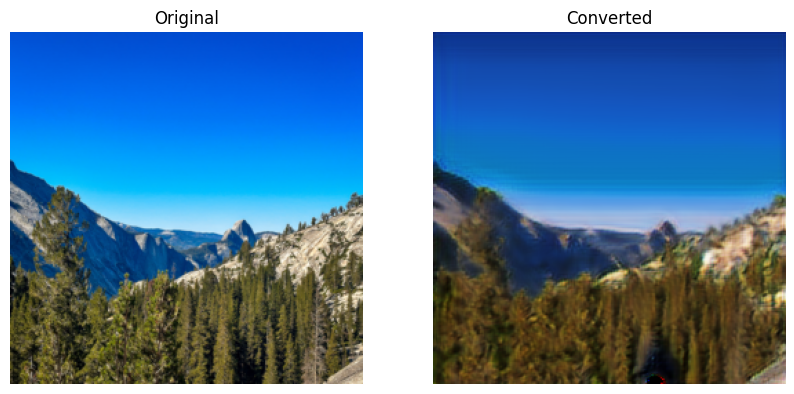

In [42]:
from torchvision import transforms
from PIL import Image


transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),

])


image_path = '/content/drive/MyDrive/DL_HW6/HW_06_Dataset/IMG_8677.jpeg'
unseen_image = Image.open(image_path).convert('RGB')


unseen_image = transform(unseen_image)

unseen_image = unseen_image.unsqueeze(0)

unseen_image = unseen_image.to(device)

with torch.no_grad():
    transformed_unseen_image = G_AB(unseen_image)


def show_single_image(original, converted):
    plt.figure(figsize=(10,8))

    # Original
    plt.subplot(1, 2, 1)
    plt.imshow(original.squeeze().permute(1, 2, 0).cpu().numpy())
    plt.title('Original')
    plt.axis('off')

    # Converted
    plt.subplot(1, 2, 2)
    converted = denormalize(converted)
    plt.imshow(converted.squeeze().permute(1, 2, 0).cpu().numpy())
    plt.title('Converted')
    plt.axis('off')

    plt.show()


show_single_image(unseen_image, transformed_unseen_image)


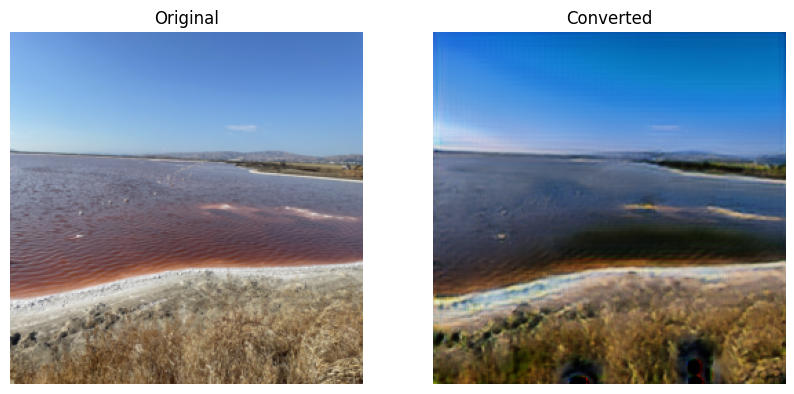

In [43]:
from torchvision import transforms
from PIL import Image


transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),

])


image_path = '/content/drive/MyDrive/DL_HW6/HW_06_Dataset/IMG_4299.jpeg'
unseen_image = Image.open(image_path).convert('RGB')


unseen_image = transform(unseen_image)

unseen_image = unseen_image.unsqueeze(0)

unseen_image = unseen_image.to(device)

with torch.no_grad():
    transformed_unseen_image = G_AB(unseen_image)


def show_single_image(original, converted):
    plt.figure(figsize=(10,8))

    # Original
    plt.subplot(1, 2, 1)
    plt.imshow(original.squeeze().permute(1, 2, 0).cpu().numpy())
    plt.title('Original')
    plt.axis('off')

    # Converted
    plt.subplot(1, 2, 2)
    converted = denormalize(converted)
    plt.imshow(converted.squeeze().permute(1, 2, 0).cpu().numpy())
    plt.title('Converted')
    plt.axis('off')

    plt.show()


show_single_image(unseen_image, transformed_unseen_image)


# REPORT

- The CycleGAN model demands substantial computational resources and time for execution, reflecting its complexity.

- Even with a limited training duration of just five epochs, the model demonstrates promising results.

- Extending the training period to include more epochs could significantly enhance the model's ability to accurately transform photographs into Monet-style paintings.

- Performance evaluations on the validation set indicate that the model is effective, with selected examples showcasing its capabilities.

- Impressively, the model successfully translates new, unseen images into Monet-inspired artworks, illustrating its robust generalization ability.